S0 = 0.4714, S1 = -0.0000


C:\Users\anuhe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\colorbar.py:1233: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -


IndexError: index 1 is out of bounds for axis 0 with size 1

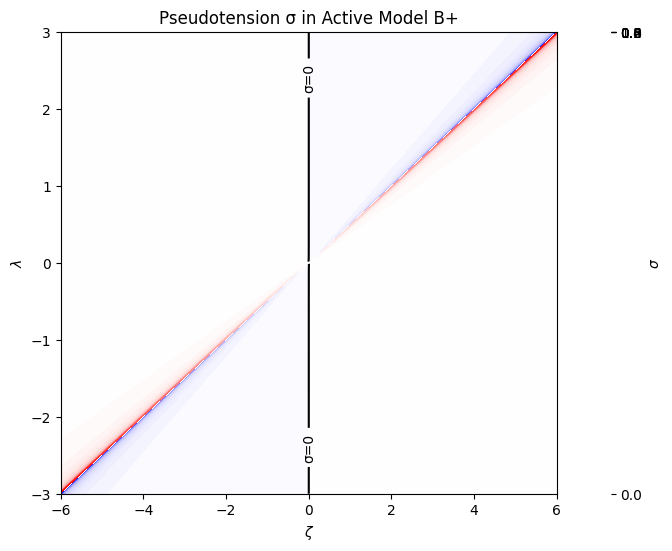

In [47]:
# Active Model B+ pseudotension phase diagram (Fig. 4(a))
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.optimize import fsolve

# Parameters (same as paper)
A = 0.25   # free energy parameter
K = 1.0    # interfacial stiffness
L = 20.0   # domain size (symmetric interface)
N = 1000   # number of points
x = np.linspace(-L, L, N)
dx = x[1] - x[0]

# Potential and its derivative
def f_prime(phi):
    return A * (phi**3 - phi)

# Solve profile: phi'' = df/dphi
def solve_interface():
    from scipy.integrate import solve_bvp
    def ode(x, y):
        return np.vstack((y[1], f_prime(y[0]) / K))
    def bc(ya, yb):
        return np.array([ya[0] + 1, yb[0] - 1])  # phi(-L)= -1, phi(L)=+1
    xmesh = np.linspace(-L, L, N)
    y_init = np.zeros((2, xmesh.size))
    y_init[0] = np.tanh(xmesh / np.sqrt(2*K/A))  # tanh init
    sol = solve_bvp(ode, bc, xmesh, y_init)
    return sol.sol(xmesh)[0]

# Compute S0 and S1
phi = solve_interface()
phi_x = np.gradient(phi, dx)
S0 = simpson(phi_x**2, x)
S1 = simpson(phi_x**2 * phi, x)
print(f"S0 = {S0:.4f}, S1 = {S1:.4f}")

# Pseudotension function
def pseudotension(zeta, lam):
    denom = (zeta - 2 * lam)
    if np.abs(denom) < 1e-4:
        return np.nan  # avoid division by zero
    return (K / denom) * (zeta * S0 - 2 * lam * S1)

# Grid for ζ and λ
zeta_vals = np.linspace(-6, 6, 400)
lambda_vals = np.linspace(-3, 3, 400)
Z, LAM = np.meshgrid(zeta_vals, lambda_vals)
SIGMA = np.vectorize(pseudotension)(Z, LAM)

# Plotting
plt.figure(figsize=(8,6))
cmap = plt.get_cmap('bwr')
plt.contourf(Z, LAM, SIGMA, levels=100, cmap=cmap)
cs = plt.contour(Z, LAM, SIGMA, levels=[0], colors='black', linewidths=1.5)
plt.clabel(cs, fmt="σ=0", colors='black')
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\lambda$")
plt.title("Pseudotension σ in Active Model B+")
plt.colorbar(label=r"$\sigma$")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Model parameters
A = -1
B = 1
K = 1

def f_prime(phi):
    return A * phi + B * phi**3

def f(phi):
    return 0.5 * A * phi**2 + 0.25 * B * phi**4


In [39]:
def compute_binodals(alpha, phi_grid=np.linspace(-2, 2, 2000)):
    dpsi_dphi = np.exp(alpha * phi_grid)
    psi = cumulative_trapezoid(dpsi_dphi, phi_grid, initial=0)
    dg_dphi = f_prime(phi_grid) * dpsi_dphi
    g = cumulative_trapezoid(dg_dphi, phi_grid, initial=0)

    mu_interp = interp1d(phi_grid, f_prime(phi_grid), kind='cubic')
    psi_interp = interp1d(phi_grid, psi, kind='cubic')
    g_interp = interp1d(phi_grid, g, kind='cubic')
    P_interp = lambda x: psi_interp(x) * mu_interp(x) - g_interp(x)

    def coexistence(vars):
        phi1, phi2 = vars
        return [mu_interp(phi1) - mu_interp(phi2), P_interp(phi1) - P_interp(phi2)]

    sol = fsolve(coexistence, [-1.0, 1.0])
    return sol[0], sol[1]


In [40]:
def solve_interface(phi1, phi2, x_domain=np.linspace(-10, 10, 600)):
    mu0 = A * phi1 + B * phi1**3

    def ode(x, y):
        phi = y[0]
        dphi_dx = y[1]
        d2phi_dx2 = (A * phi + B * phi**3 - mu0) / K
        return np.vstack([dphi_dx, d2phi_dx2])

    def bc(ya, yb):
        return [ya[0] - phi1, yb[0] - phi2]

    init_phi = phi1 + (phi2 - phi1) * (np.tanh(x_domain) + 1)/2
    guess = np.vstack([init_phi, np.gradient(init_phi, x_domain)])
    sol = solve_bvp(ode, bc, x_domain, guess, max_nodes=10000)
    return sol.x, sol.y[0], sol.y[1]


In [41]:
def compute_sigma(zeta, lam, x, phi0, dphi_dx):
    S0 = simpson(dphi_dx**2, x)
    S1 = simpson(phi0 * dphi_dx**2, x)
    denom = zeta - 2 * lam
    if np.abs(denom) < 1e-6:
        return np.nan
    return K / denom * (zeta * S0 - 2 * lam * S1)


In [42]:
zeta_vals = np.linspace(-5, 5, 100)
lambda_vals = np.linspace(-5, 5, 100)
sigma_vals = np.zeros((len(zeta_vals), len(lambda_vals)))

for i, zeta in enumerate(zeta_vals):
    for j, lam in enumerate(lambda_vals):
        alpha = (zeta - 2 * lam) / K
        try:
            phi1, phi2 = compute_binodals(alpha)
            x, phi0, dphi_dx = solve_interface(phi1, phi2)
            sigma = compute_sigma(zeta, lam, x, phi0, dphi_dx)
            sigma_vals[i, j] = sigma
        except:
            sigma_vals[i, j] = np.nan


C:\Users\anuhe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\colorbar.py:1232: RuntimeWarning: invalid value encountered in subtract
  y = (self._boundaries - self._boundaries[self._inside][0])
C:\Users\anuhe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\colorbar.py:1233: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -


ValueError: Axis limits cannot be NaN or Inf

C:\Users\anuhe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\transforms.py:2651: RuntimeWarning: divide by zero encountered in scalar divide
  y_scale = 1.0 / inh


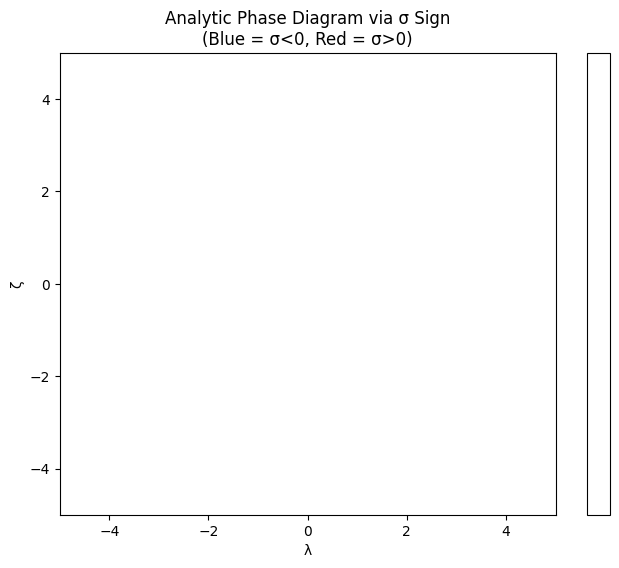

In [43]:
plt.figure(figsize=(8,6))
Z, L = np.meshgrid(lambda_vals, zeta_vals)
plt.contourf(L, Z, sigma_vals, levels=[-np.inf, 0, np.inf], colors=["#2980b9", "#e74c3c"], alpha=0.8)
plt.xlabel("λ")
plt.ylabel("ζ")
plt.title("Analytic Phase Diagram via σ Sign\n(Blue = σ<0, Red = σ>0)")
plt.colorbar(label="σ value")
plt.grid(True)
plt.tight_layout()
plt.show()
